<a href="https://colab.research.google.com/github/HumaSatti/Depression-Detection-By-ML-Deep-Learning-Model/blob/main/Random_forest_Recreate_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nurse-stress-prediction-wearable-sensors:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4110234%2F7125235%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240722%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240722T165124Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6b28f1e663ccdae5b4020bde170baa03ea91c5269f8eccd0d59748ceee7779a867625849bf6d7e9ff7bd3b3f3ceb35b06607284cceaf3558ca88f9d9ecf47bdb43430b0f57712f25e4df67fcfeebeada81ae4476223d591c96f6035f16eed42258efb1d4f0dec77df0307db541d539b5a9f9e29d28e99fd58a6ef1cc36abbe8f91d5f30507ddf36e4acb6a25925c8c8f0e7c6190767d730d576230abf802b8cb7e1c81b819e56638a096dfdec8d45abee597ad5e0b7ffba42e06b7453423497d1f924c14537fa0d14421a06e90bfd0c5a8abb37b0c4b2aae7e3c6b801f8f5ffe9f615d09e432936bbf9b16e1d7a7d4ad420d00da9dbe30d2653861b5894bcb35'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 79877492 bytes downloaded
Downloaded and uncompressed: nurse-stress-prediction-wearable-sensors
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the dataset
df = pd.read_csv('/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv', low_memory=False, parse_dates=['datetime'])
df

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


In [5]:
# Display basic information about the dataset
print("Dataset Information:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nFirst 5 Rows of the Dataset:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509051 entries, 0 to 11509050
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   X         float64       
 1   Y         float64       
 2   Z         float64       
 3   EDA       float64       
 4   HR        float64       
 5   TEMP      float64       
 6   id        object        
 7   datetime  datetime64[ns]
 8   label     float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 790.3+ MB
None

Dataset Description:
                  X             Y             Z           EDA            HR  \
count  1.150905e+07  1.150905e+07  1.150905e+07  1.150905e+07  1.150905e+07   
mean  -2.823775e+01 -9.091032e-01  2.382449e+01  3.502127e+00  8.576090e+01   
min   -1.280000e+02 -1.280000e+02 -1.280000e+02  0.000000e+00  5.100000e+01   
25%   -5.200000e+01 -1.900000e+01  4.000000e+00  2.242060e-01  7.672000e+01   
50%   -3.300000e+01  1.000000e+00  2.500

In [6]:
df.datetime

0          2020-07-08 14:03:00.000000000
1          2020-07-08 14:03:00.031249920
2          2020-07-08 14:03:00.062500096
3          2020-07-08 14:03:00.093750016
4          2020-07-08 14:03:00.124999936
                        ...             
11509046   2020-07-23 17:28:59.875000064
11509047   2020-07-23 17:28:59.906249984
11509048   2020-07-23 17:28:59.937499904
11509049   2020-07-23 17:28:59.968750080
11509050   2020-07-23 17:29:00.000000000
Name: datetime, Length: 11509051, dtype: datetime64[ns]

In [7]:
# Extract datetime features
# Convert 'datetime' to datetime object and extract features
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
# Data Preparation
X = df[['X', 'Y', 'Z', 'TEMP', 'HR', 'EDA']]  # Features
y = df['label']  # Target variable


In [10]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Feature Scaling (if required)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error


In [14]:
# Train a random forest classifier on the training data
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Evaluate the model on the testing data
y_pred = RFC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9967130229197793


In [16]:
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_pred, average='weighted'))

Precision: 0.9967160494572419
Recall: 0.9967130229197793
F1-score: 0.9967070258939938


In [17]:
# Evaluate the model performance using R-squared and RMSE metrics
print('R-squared score for id prediction:', r2_score(y_test, y_pred))
print('RMSE for id prediction:', mean_squared_error(y_test, y_pred, squared=False))

R-squared score for id prediction: 0.9854372495113038
RMSE for id prediction: 0.09520820207233134


In [18]:
# Classification Report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    432097
         1.0       1.00      0.98      0.99    160853
         2.0       1.00      1.00      1.00   1708861

    accuracy                           1.00   2301811
   macro avg       1.00      0.99      0.99   2301811
weighted avg       1.00      1.00      1.00   2301811



In [19]:
# Precision, Recall, F1-Score, and Support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f'\nPrecision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')



Precision: 0.9967
Recall: 0.9967
F1 Score: 0.9967


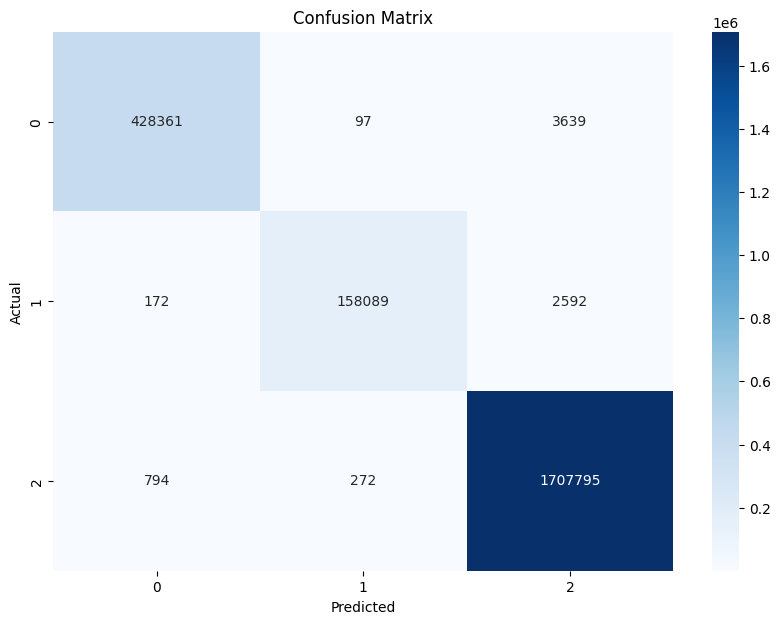

In [20]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
RFC



RandomForestClassifier(random_state=42)

In [26]:
y_pred

array([2., 0., 2., ..., 2., 2., 0.])

In [28]:
print('Confusion Matrix:')
print(conf_mat)

Confusion Matrix:
[[ 428361      97    3639]
 [    172  158089    2592]
 [    794     272 1707795]]


In [30]:
print("Random Forest  Model Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest  Model Performance:
[[ 428361      97    3639]
 [    172  158089    2592]
 [    794     272 1707795]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    432097
         1.0       1.00      0.98      0.99    160853
         2.0       1.00      1.00      1.00   1708861

    accuracy                           1.00   2301811
   macro avg       1.00      0.99      0.99   2301811
weighted avg       1.00      1.00      1.00   2301811

